In [1]:
from metalib.utils import load_hist_data
from scipy.signal import resample

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import vectorbt as vbt
import numpy as np

In [20]:
eurusd = load_hist_data("AUDCHF", 2022)

C:\Users\Trismegist\anaconda3\envs\adonys\lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [21]:
donchian = eurusd.resample('15min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})
donchian = donchian.shift()

In [22]:
upper_donchian = donchian.high.rolling(8).max()
lower_donchian = donchian.low.rolling(8).min()
channels = pd.concat({'upper': upper_donchian, 'lower': lower_donchian}, axis=1)

In [23]:
channels.index = pd.to_datetime(channels.index)  # Ensure the index is datetime
resampled_channels = channels.resample("min").ffill()

resampled_channels = resampled_channels.reindex(eurusd.index).ffill()
resampled_channels

,upper,lower
time,,
2022-01-02 17:10:00,NaN,NaN
2022-01-02 17:11:00,NaN,NaN
2022-01-02 17:12:00,NaN,NaN
2022-01-02 17:13:00,NaN,NaN
2022-01-02 17:14:00,NaN,NaN
...,...,...
2022-12-30 16:54:00,0.63044,0.62878
2022-12-30 16:55:00,0.63044,0.62878
2022-12-30 16:56:00,0.63044,0.62878


In [24]:
resampled_channels.index == eurusd.index

array([ True,  True,  True, ...,  True,  True,  True])

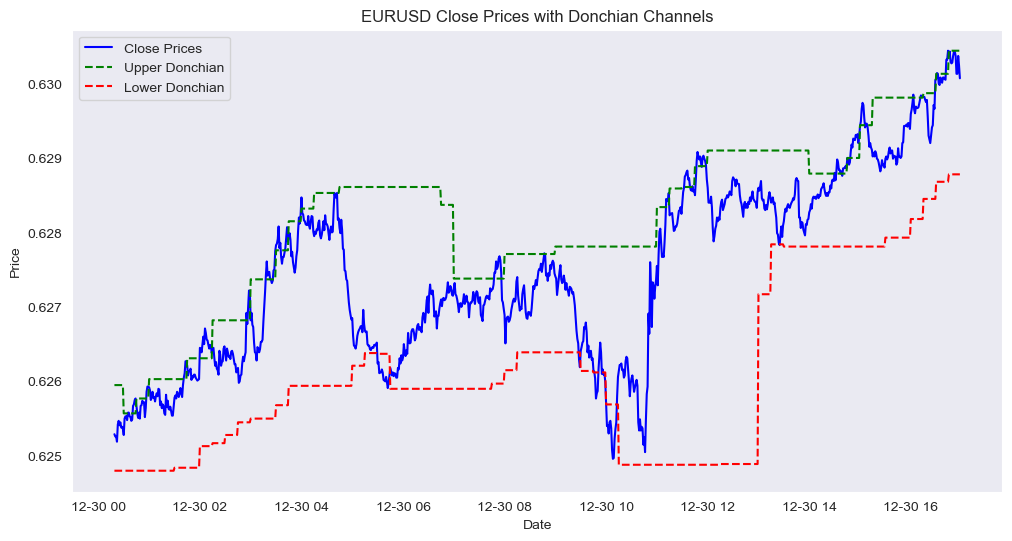

In [34]:
# Plot prices and lower/upper bound
n_tail = 1000  # Set to None to plot all lines

plt.figure(figsize=(12, 6))

# If n_tail is specified, slice the data; otherwise, use the full dataset
eurusd_plot = eurusd if n_tail is None else eurusd.tail(n_tail)
resampled_channels_plot = resampled_channels if n_tail is None else resampled_channels.tail(n_tail)

plt.plot(eurusd_plot.index, eurusd_plot['close'], label='Close Prices', color='blue')
plt.plot(resampled_channels_plot.index, resampled_channels_plot['upper'], label='Upper Donchian', color='green', linestyle='--')
plt.plot(resampled_channels_plot.index, resampled_channels_plot['lower'], label='Lower Donchian', color='red', linestyle='--')

plt.title('EURUSD Close Prices with Donchian Channels')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


In [26]:
long_entries.value_counts()

False    367666
True       5199
Name: count, dtype: int64

In [27]:
close = eurusd['close']

In [28]:
crossed_above_upper = close.vbt.crossed_above(resampled_channels.upper)
crossed_below_lower = close.vbt.crossed_below(resampled_channels.lower)

In [29]:
long_entries = crossed_below_lower
short_entries = crossed_above_upper

crossed_above_upper = close.vbt.crossed_above(resampled_channels.upper)
crossed_below_lower = close.vbt.crossed_below(resampled_channels.lower)
vol = close.diff().rolling(60*24*4).std()**np.sqrt(15)

long_sl = close - 0.04*vol  # Long stop loss is below the entry price
long_tp = close + 0.2*vol  # Long take profit is above the entry price
short_sl = close + 0.04*vol  # Short stop loss is above the entry price
short_tp = close - 0.2*vol  # Short take profit is below the entry price

# Set up the portfolio with long and short configurations
portfolio = vbt.Portfolio.from_signals(
    close,
    entries=long_entries,
    short_entries=short_entries,  # Combine long and short entries
    exits=None,  # Manage exits via TP/SL
    sl_stop=np.where(long_entries, long_sl, short_sl),  # Adjust SL based on trade type
    tp_stop=np.where(long_entries, long_tp, short_tp),  # Adjust TP based on trade type
    freq='min',  # Daily frequency, adjust as needed
    accumulate=True
)


In [30]:
portfolio.stats()

Start                               2022-01-02 17:10:00
End                                 2022-12-30 16:58:00
Period                                257 days 18:56:00
Start Value                                       100.0
End Value                                     185.44801
Total Return [%]                               85.44801
Benchmark Return [%]                          -4.576777
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               4.607737
Max Drawdown Duration                  23 days 17:34:00
Total Trades                                       1775
Total Closed Trades                                1774
Total Open Trades                                     1
Open Trade PnL                                -0.375311
Win Rate [%]                                  69.052988
Best Trade [%]                                 0.764331
Worst Trade [%]                               -2

In [31]:
portfolio.plot_cum_returns()

FigureWidget({
    'data': [{'line': {'color': '#7f7f7f'},
              'name': 'Benchmark',
              'showlegend': True,
              'type': 'scatter',
              'uid': '4aea453f-93b4-401a-aa04-c66659debca5',
              'x': array([datetime.datetime(2022, 1, 2, 17, 10),
                          datetime.datetime(2022, 1, 2, 17, 11),
                          datetime.datetime(2022, 1, 2, 17, 12), ...,
                          datetime.datetime(2022, 12, 30, 16, 56),
                          datetime.datetime(2022, 12, 30, 16, 57),
                          datetime.datetime(2022, 12, 30, 16, 58)], dtype=object),
              'y': array([1.        , 0.99977283, 0.99977283, ..., 0.95468658, 0.95448969,
                          0.95423223])},
             {'hoverinfo': 'skip',
              'line': {'color': 'rgba(0, 0, 0, 0)', 'width': 0},
              'opacity': 0,
              'showlegend': False,
              'type': 'scatter',
              'uid': '0f244798-97

In [281]:
portfolio.plot_trades()

KeyboardInterrupt: 

In [32]:
close.diff().rolling().std().plot(figsize=(20, 6))
plt.show()

TypeError: rolling() missing 1 required positional argument: 'window'

In [323]:
close

time
2022-01-02 17:03:00    1.13690
2022-01-02 17:04:00    1.13689
2022-01-02 17:05:00    1.13692
2022-01-02 17:06:00    1.13652
2022-01-02 17:07:00    1.13682
                        ...   
2022-12-30 16:54:00    1.07001
2022-12-30 16:55:00    1.07001
2022-12-30 16:56:00    1.07008
2022-12-30 16:57:00    1.07030
2022-12-30 16:58:00    1.07054
Name: close, Length: 388105, dtype: float64

In [12]:
vol = close.pct_change().rolling(15).apply(lambda x: np.sqrt(np.sum(x**2)), engine='numba', raw=True)

In [13]:
def run_portfolio(vol_scale_sl, vol_scale_tp):

    # Define volatility for stop loss and take profit calculati
    # Calculate take profits and stop losses based on volatility
    long_sl = vol_scale_sl * vol  # Long stop loss
    long_tp = vol_scale_tp * vol  # Long take profit
    short_sl = vol_scale_sl * vol  # Short stop loss
    short_tp = vol_scale_tp * vol  # Short take profit

    # Set up the portfolio with long and short configurations
    portfolio = vbt.Portfolio.from_signals(
        close,
        entries=long_entries,
        # sl_stop=long_sl,
        # tp_stop=long_tp,
        short_entries=short_entries,
        exits=None,  # Manage exits via TP/SL
        sl_stop=np.where(long_entries, long_sl, short_sl),
        tp_stop=np.where(long_entries, long_tp, short_tp),
        freq='min',  # Assuming minute frequency data
        accumulate=False
    )
    return portfolio.stats()['Sharpe Ratio']

In [14]:
from tqdm.notebook import tqdm

In [15]:
scale_factors = np.logspace(-2, 1, 20)  # Example scale factors
results = []

for sl_scale in tqdm(scale_factors, desc='SL Scale Loop'):
    # Using tqdm for the inner loop
    for tp_scale in tqdm(scale_factors, desc='TP Scale Loop', leave=False):
        sharpe = run_portfolio(sl_scale, tp_scale)
        results.append({'SL Scale': sl_scale, 'TP Scale': tp_scale, 'Sharpe Ratio': sharpe})

results_df = pd.DataFrame(results)
print(results_df)

SL Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

TP Scale Loop:   0%|          | 0/20 [00:00<?, ?it/s]

     SL Scale   TP Scale  Sharpe Ratio
0        0.01   0.010000      1.279744
1        0.01   0.014384      1.279829
2        0.01   0.020691      1.095432
3        0.01   0.029764      1.220468
4        0.01   0.042813      1.232142
..        ...        ...           ...
395     10.00   2.335721      2.123842
396     10.00   3.359818      1.549538
397     10.00   4.832930      1.543631
398     10.00   6.951928      1.585621
399     10.00  10.000000      1.606718

[400 rows x 3 columns]


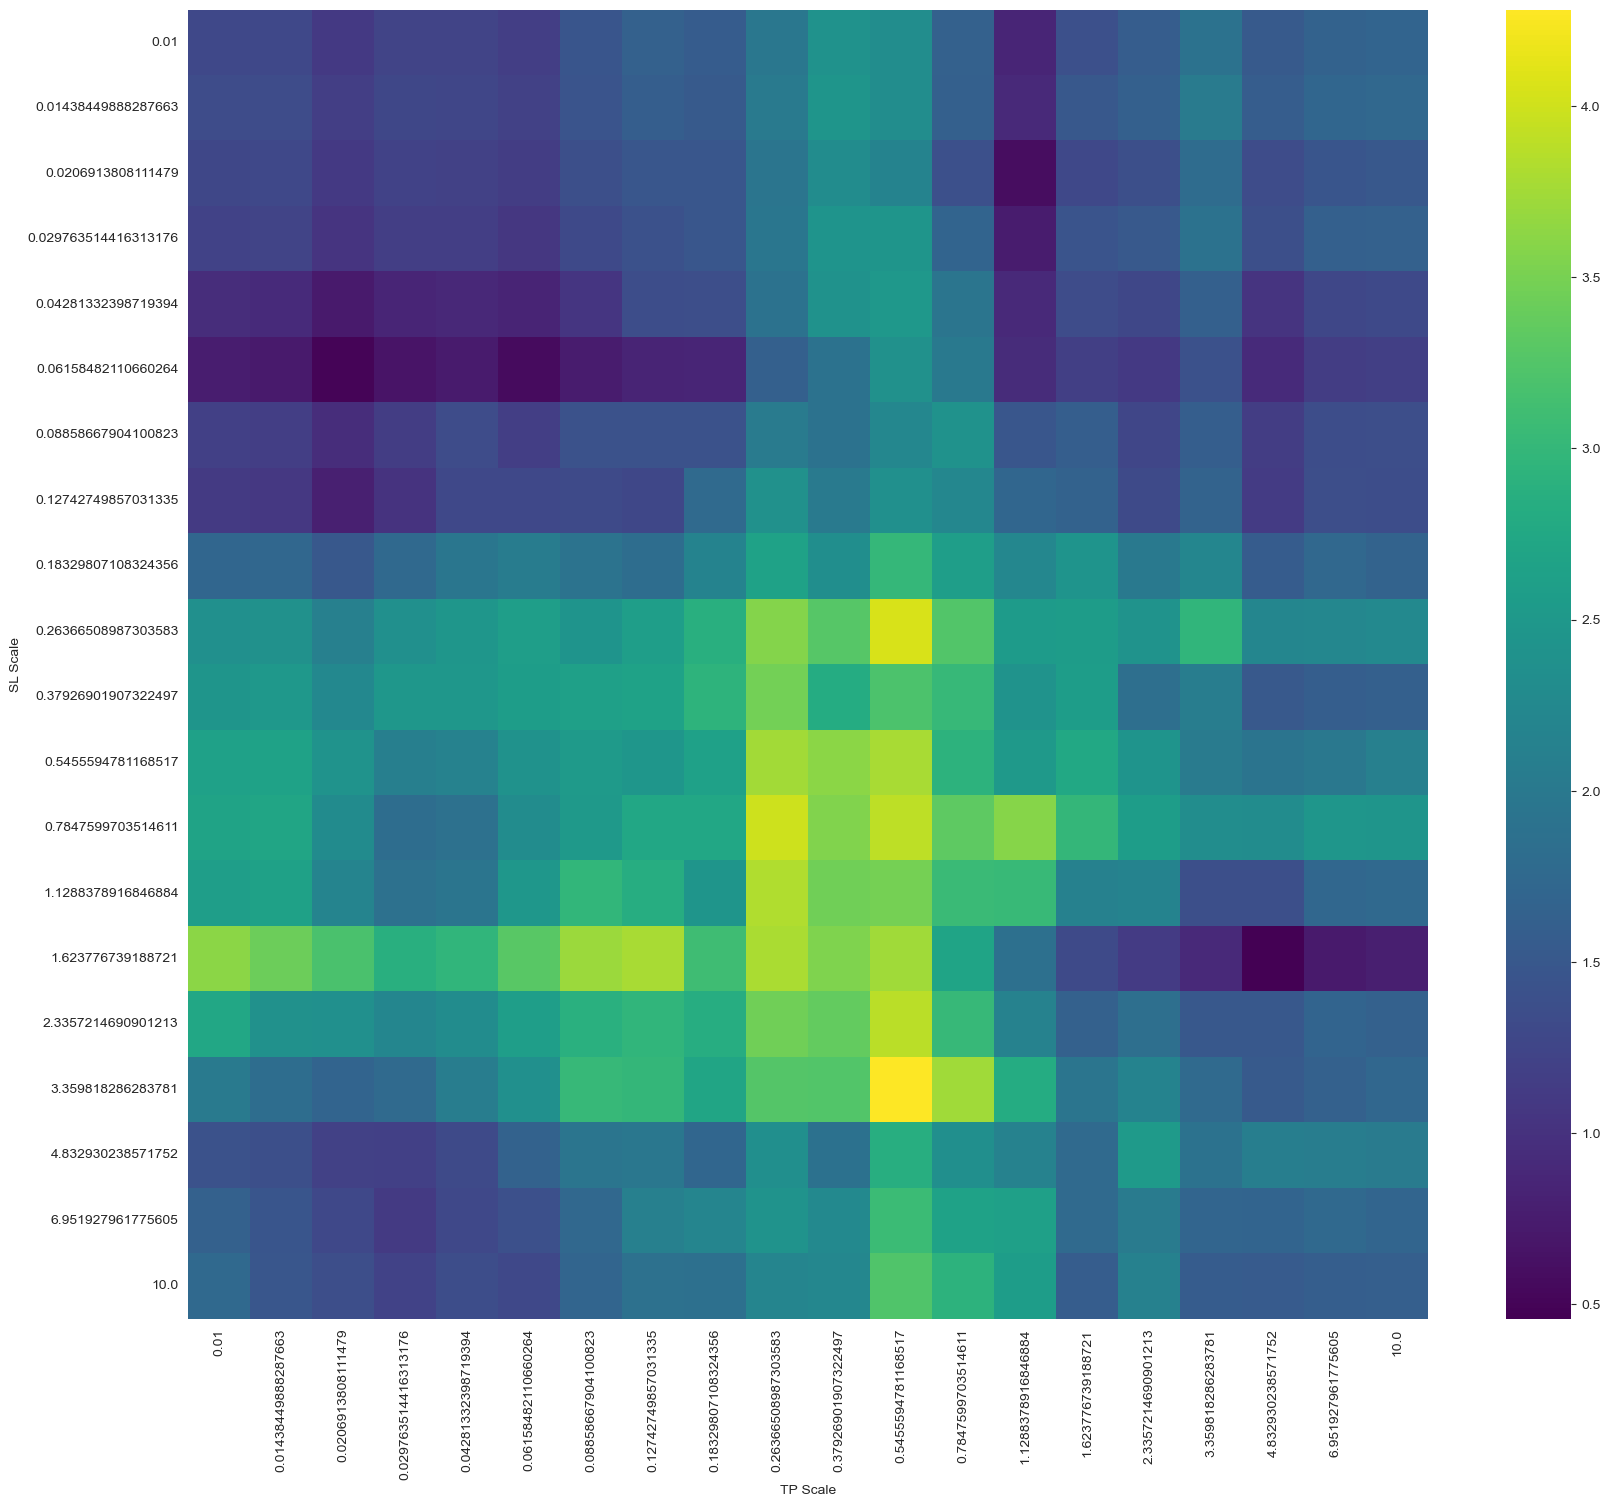

In [16]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 17))

sns.heatmap(results_df.pivot(index='SL Scale', columns='TP Scale', values='Sharpe Ratio'), annot=False, cmap='viridis', ax=ax)
plt.show()

In [17]:
results_df.loc[:, "Risk Reward"] = results_df['TP Scale'] / results_df['SL Scale']

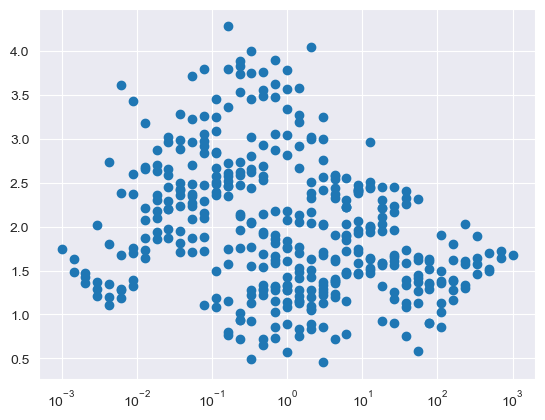

In [18]:
plt.scatter(results_df['Risk Reward'], results_df['Sharpe Ratio'])
plt.xscale('log')
plt.show()